In [ ]:
## Import Required Libraries
import os
import openslide
from openslide import open_slide

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import glob

from sklearn.model_selection import train_test_split

from PIL import Image

In [2]:
# Open with OPENSLIDE to get the full package to handle TIFF / Pyramidal format of filetype
slide = open_slide('images/wsi_ovary.svs')

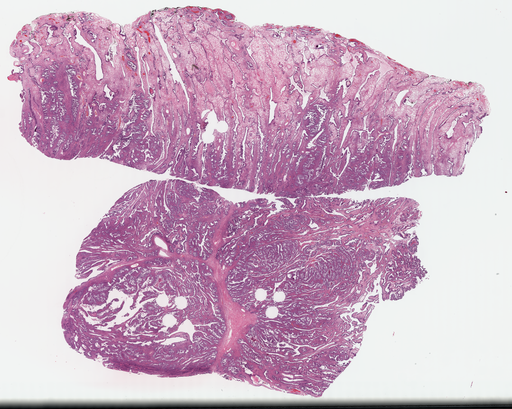

In [ ]:
# preview slide:
thumb = slide.get_thumbnail((512,512))
thumb

## IMPORT created tiles from slide using HistoClean module

In [4]:
# Path to folder
tile_folder = './images/tiled_images/wsi_ovary'

# Get all image paths (supports png/jpg/jpeg)
image_paths = sorted(glob.glob(os.path.join(tile_folder, '*.png')))  # or '*.jpg'

# Load images
tiles = []
for path in image_paths:
    img = Image.open(path).convert('RGB')  # Convert to 3 channels
    img = img.resize((512, 512))  # optional, if size is inconsistent
    tiles.append(np.array(img))

# Stack into array: shape (N, 512, 512, 3)
X = np.stack(tiles)

X = X.astype(np.float32) / 255.0

In [5]:
print("Shape of X:", X.shape)  # (num_tiles, 512, 512, 3)
print("Type of X:", X.dtype)  # Should be float32

Shape of X: (1306, 512, 512, 3)
Type of X: float32


In [8]:
# 80% train, 20% test
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Type of X_train:", X_train.dtype)  # Should be float32
print("Type of X_test:", X_test.dtype)  # Should be float32

Train shape: (1044, 512, 512, 3)
Test shape: (262, 512, 512, 3)
Type of X_train: float32
Type of X_test: float32


# Build and train the autoencoder

In [9]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Lambda
import tensorflow.keras.backend as K

input_shape = (512, 512, 3)

In [ ]:
# --- Encoder ---
inputs = layers.Input(shape=input_shape)

x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
x = layers.MaxPooling2D(2, padding='same')(x)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2, padding='same')(x) 
# x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
# x = layers.MaxPooling2D(2, padding='same')(x) 
# x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
# x = layers.MaxPooling2D(2, padding='same')(x) 

# Flatten spatial grid into a sequence: (batch, 128*128, 64)
x = layers.Reshape((128 * 128, 64))(x)

# Apply Conv1D across the sequence (optional kernel size = 1 or 3)
x = layers.Conv1D(1, kernel_size=1, activation='linear')(x)  # (batch, 16384, 1)

# Reshape to (128, 128)
latent = layers.Reshape((128, 128))(x)

In [ ]:
# --- Decoder ---
# Add channel dimension back → (128, 128, 1)
x = Lambda(lambda x: K.expand_dims(x, axis=-1))(latent)

# Restore to 64 filters
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)

#x = layers.Conv2DTranspose(256, 3, strides=2, activation='relu', padding='same')(x)
# x = layers.Conv2DTranspose(128, 3, strides=2, activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(32, 3, strides=2, activation='relu', padding='same')(x)

# Final Output
outputs = layers.Conv2D(3, 3, activation='sigmoid', padding='same')(x)

In [13]:
autoencoder = models.Model(inputs, outputs)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 512, 512, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 16384, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 16384, 1)       │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 256, 256, 64)   │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 512, 512, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 512, 512, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,356 (298.27 KB)

 Trainable params: 76,356 (298.27 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
autoencoder.fit(X_train, X_train, epochs=100, batch_size=8, shuffle=True, validation_data=(X_test, X_test))

Epoch 1/100


2025-07-09 10:52:33.222800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


131/131 ━━━━━━━━━━━━━━━━━━━━ 35s 244ms/step - loss: 0.6261 - val_loss: 0.5451
Epoch 2/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 30s 224ms/step - loss: 0.5413 - val_loss: 0.5386
Epoch 3/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 34s 254ms/step - loss: 0.5357 - val_loss: 0.5379
Epoch 4/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 34s 253ms/step - loss: 0.5337 - val_loss: 0.5367
Epoch 5/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 33s 252ms/step - loss: 0.5400 - val_loss: 0.5363
Epoch 6/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 34s 255ms/step - loss: 0.5330 - val_loss: 0.5375
Epoch 7/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 32s 247ms/step - loss: 0.5341 - val_loss: 0.5360
Epoch 8/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 33s 250ms/step - loss: 0.5329 - val_loss: 0.5357
Epoch 9/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 33s 253ms/step - loss: 0.5337 - val_loss: 0.5358
Epoch 10/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 33s 248ms/step - loss: 0.5328 - val_loss: 0.5356
Epoch 11/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 33s 252ms/step - loss: 0.5328 - val_loss: 0.5355
Epoch 12/100
131/131

## Visualise the reconstructions side by side 

In [15]:
def show_reconstructions(model, X_data, n=5):
    """
    Show 'n' original and reconstructed images side-by-side.
    
    Parameters:
        model: trained autoencoder
        X_data: input data, shape (N, 512, 512, 3)
        n: number of images to display
    """
    decoded_imgs = model.predict(X_data[:n])

    plt.figure(figsize=(2 * n, 4))
    for i in range(n):
        # Original image
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(X_data[i])
        plt.title("Original")
        plt.axis("off")

        # Reconstructed image
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i])
        plt.title("Reconstructed")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


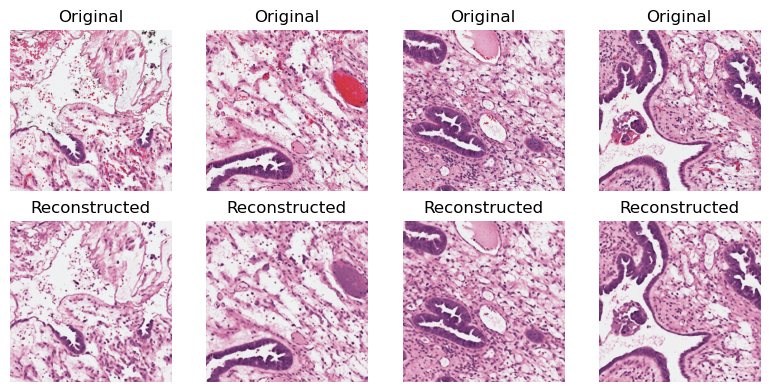

In [16]:
show_reconstructions(autoencoder, X, n=4)

## Save images to disk for size comparison. 

In [17]:
from tensorflow.keras.models import Model

# Suppose this is your encoder model:
encoder = Model(inputs=autoencoder.input, outputs=latent)

# Select an image
sample = X[1:2]  # shape (1, H, W, C)

# Get latent vector
compressed = encoder.predict(sample) 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


In [18]:
sample.shape

(1, 512, 512, 3)

In [19]:
compressed.shape

(1, 128, 128)

In [20]:
np.save('compressed_sample.npy', compressed)

In [21]:
compressed.tofile('compressed_sample.bin')

In [22]:
# Assuming input image is scaled 0-1 and needs converting back to 0–255
img = (sample[0] * 255).astype(np.uint8)

# Save as PNG
Image.fromarray(img).save("original_image.png")

In [23]:
# copy of above make compressed to img ??
comp = (compressed[0] * 255).astype(np.uint8)

# Save as PNG
Image.fromarray(comp).save("compressed_image.png")

In [24]:
decoded = autoencoder.predict(X[1:2])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


In [25]:
decoded.shape

(1, 512, 512, 3)

In [26]:
# output image is scaled 0-1 and needs converting back to 0–255
decoded_img = (decoded[0] * 255).astype(np.uint8)

# Save as PNG
Image.fromarray(decoded_img).save("reconstructed_image.png")

In [27]:
import os

original_size = os.path.getsize("original_image.png")
compressed_image_size = os.path.getsize("compressed_image.png")
compressed_size = os.path.getsize("compressed_sample.npy")
compressed_bin = os.path.getsize("compressed_sample.bin")
reconstructed_size = os.path.getsize("reconstructed_image.png")

print(f"Original image size: {original_size / 1024:.2f} KB")
print(f"Compressed image size: {compressed_image_size / 1024:.2f} KB")
print(f"Compressed latent size npy: {compressed_size / 1024:.2f} KB")
print(f"Compressed latent size bin: {compressed_bin / 1024:.2f} KB")
print(f"Reconstructed image size: {reconstructed_size / 1024:.2f} KB")

Original image size: 534.43 KB
Compressed image size: 16.15 KB
Compressed latent size npy: 64.12 KB
Compressed latent size bin: 64.00 KB
Reconstructed image size: 411.61 KB


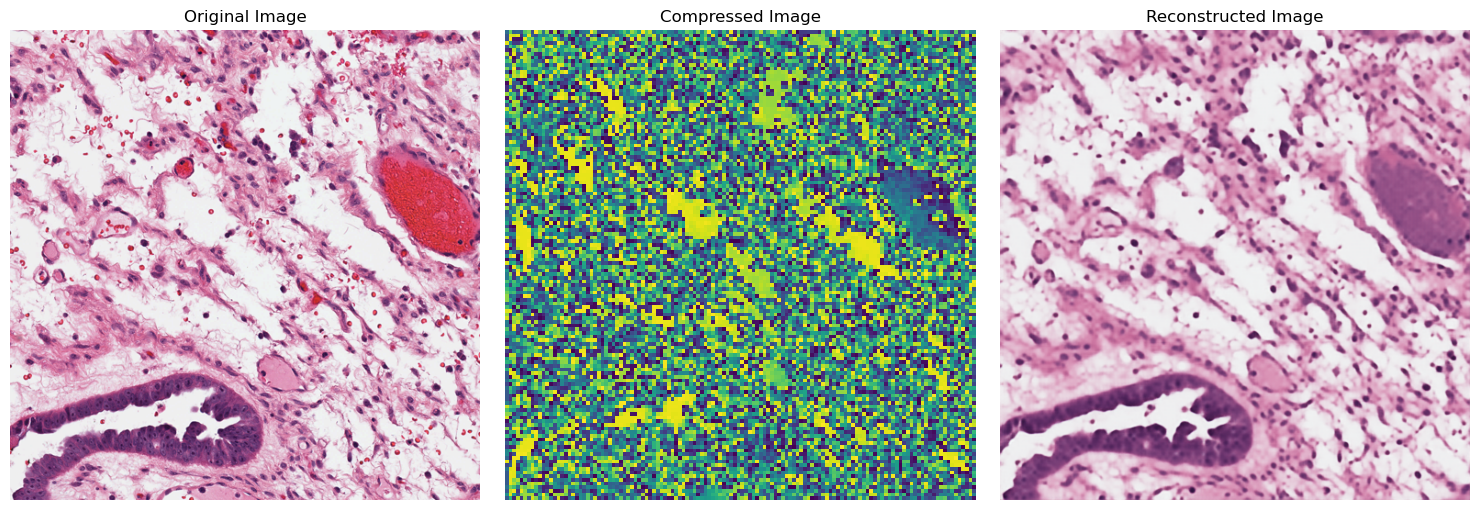

In [28]:
# Load the images
original = Image.open("original_image.png")
compressed = Image.open("compressed_image.png")
reconstructed = Image.open("reconstructed_image.png")

# Get file sizes in KB
# original_size = os.path.getsize("original_image.png") / 1024
# compressed_size = os.path.getsize("compressed_image.png") / 1024
# reconstructed_size = os.path.getsize("reconstructed_image.png") / 1024

# Create side-by-side display
plt.figure(figsize=(15, 5))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(original)
plt.title(f"Original Image") #\n{original_size:.2f} KB
plt.axis("off")

# Compressed image
plt.subplot(1, 3, 2)
plt.imshow(compressed)
plt.title(f"Compressed Image") #\n{compressed_size:.2f} KB")
plt.axis("off")

# Reconstructed
plt.subplot(1, 3, 3)
plt.imshow(reconstructed)
plt.title(f"Reconstructed Image") #\n{reconstructed_size:.2f} KB")
plt.axis("off")

# Show the plot
plt.tight_layout()
plt.show()

## Extract latent vectors from new WSI_heart files using autoencoder to predict

In [29]:
# Path to folder
tile_folder = './images/tiled_images/wsi_heart'

# Get all image paths (supports png/jpg/jpeg)
image_paths = sorted(glob.glob(os.path.join(tile_folder, '*.png')))  # or '*.jpg'

# Load images
tiles = []
for path in image_paths:
    img = Image.open(path).convert('RGB')  # Convert to 3 channels
    img = img.resize((512, 512))  # optional, if size is inconsistent
    tiles.append(np.array(img))

# Stack into array: shape (N, 512, 512, 3)
Y = np.stack(tiles)

Y = Y.astype(np.float32) / 255.0

In [30]:
print("Shape of Y:", Y.shape)  # (num_tiles, 512, 512, 3)
print("Type of Y:", Y.dtype)  # Should be float32

Shape of Y: (115, 512, 512, 3)
Type of Y: float32


In [ ]:
encoder = models.Model(inputs, latent)
latent_vectors = encoder.predict(Y)  # Shape: (N, 128, 128)

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step WARNING:tensorflow:5 out of the last 7 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x36119ad40> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step


In [32]:
latent_flat = latent_vectors.reshape(latent_vectors.shape[0], -1)  # (N, features)

In [33]:
latent_flat.shape

(115, 16384)

# Try to calculate the loss between original vs reconstructed image.

In [34]:
# Binary Crossentropy (BCE) is a loss function that measures the difference between two probability distributions — in our case, the original and reconstructed images interpreted as probabilities per pixel.
from tensorflow.keras.losses import BinaryCrossentropy

# Reconstruct the tiles
reconstructed = autoencoder.predict(Y)

# Define the BCE loss object
bce = BinaryCrossentropy()

# Compute per-image loss
per_image_loss = [bce(Y[i], reconstructed[i]).numpy() for i in range(len(Y))]

# Average loss across all tiles
average_loss = np.mean(per_image_loss)

print(f"BCE Loss for each image: {per_image_loss}\n")
print(f"Average Reconstruction Loss (BCE): {average_loss:.5f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step
BCE Loss for each image: [0.34916118, 0.41804147, 0.54083705, 0.5699792, 0.5787797, 0.5802823, 0.58241093, 0.58461624, 0.5747784, 0.51477706, 0.34813568, 0.50597274, 0.4378785, 0.54298854, 0.56681216, 0.577724, 0.55677706, 0.58681536, 0.5904207, 0.58697295, 0.5712869, 0.37993902, 0.5069245, 0.55838937, 0.51454556, 0.35102743, 0.5401455, 0.5601718, 0.56608355, 0.58164537, 0.58715206, 0.5899277, 0.59129316, 0.5839797, 0.52095354, 0.5525924, 0.5629736, 0.56016326, 0.5111432, 0.5148428, 0.5607811, 0.57558954, 0.58523566, 0.59048444, 0.5898179, 0.58796763, 0.37991402, 0.546741, 0.5423435, 0.5723735, 0.574034, 0.5536308, 0.5206615, 0.54339105, 0.5844452, 0.5882072, 0.58945864, 0.58705676, 0.3810107, 0.5360747, 0.44191912, 0.52102894, 0.38579664, 0.56553006, 0.5445169, 0.5709064, 0.5774474, 0.56453633, 0.54440105, 0.58886516, 0.58739793, 0.5840515, 0.36308518, 0.5218388, 0.5290019, 0.57023287, 0.5649907, 0.56896985, 0.5406056, 0.42623517, 0.36001542, 0.4

In [35]:
# This is the most common for pixel-wise comparison.
# Calculate per-tile MSE
mse_losses = np.mean((Y - reconstructed) ** 2, axis=(1, 2, 3))  # shape: (N,)

# Calculate overall average MSE - LOWER IS BETTER
average_mse = np.mean(mse_losses)

print(f"MSE Loss for each image: {mse_losses}\n")
print(f"Average Reconstruction Loss (MSE): {average_mse:.5f}")

MSE Loss for each image: [0.00108457 0.00241498 0.00428104 0.005032   0.00510167 0.0049009
 0.00548963 0.00511523 0.00430094 0.00246332 0.00163373 0.00334
 0.00239924 0.00413082 0.00522688 0.00514101 0.00452563 0.00520384
 0.00559249 0.00544412 0.00437047 0.0015809  0.00299026 0.00455748
 0.0035863  0.00154528 0.00427318 0.00541854 0.00505524 0.0054622
 0.00525565 0.00568234 0.00571202 0.00493236 0.00359929 0.00441497
 0.00529244 0.00514114 0.00379417 0.00466643 0.00636064 0.00586883
 0.00623614 0.00639513 0.00662592 0.00585988 0.00166233 0.0045743
 0.00470845 0.00559491 0.00567354 0.0049251  0.00369386 0.00614183
 0.00648528 0.0061552  0.00656567 0.00595163 0.00189895 0.00399476
 0.0017415  0.00227684 0.00130363 0.00507812 0.0048099  0.00551621
 0.00574158 0.00514362 0.00409687 0.00613668 0.00665967 0.00611477
 0.00163173 0.00396153 0.00428362 0.00471996 0.00530069 0.00455007
 0.00455761 0.00262282 0.00139365 0.00376334 0.0052146  0.00341997
 0.00429538 0.00407196 0.00437339 0.0039917

In [36]:
# Calculate Structural Similarity Index (SSIM)
ssim_val = tf.image.ssim(Y, reconstructed, max_val=1.0)

# Calculate overall average SSIM - HIGHER IS BETTER
average_ssim = np.mean(ssim_val)

print(f"SSIM Loss for each image: {ssim_val}\n")
print(f"Average SSIM Loss: {average_ssim:.5f}")

SSIM Loss for each image: [0.7400713  0.6062728  0.4690963  0.44513598 0.44964632 0.4490973
 0.44920886 0.45158553 0.46517584 0.5464101  0.7115936  0.5087558
 0.59034866 0.4728695  0.43788943 0.44059157 0.51250607 0.46030235
 0.45511302 0.47282982 0.47689304 0.6881879  0.5173348  0.4482471
 0.49559256 0.717683   0.4610606  0.45985952 0.46907255 0.43760785
 0.45106754 0.45277652 0.42480102 0.45622936 0.4974936  0.4517655
 0.42891827 0.4201858  0.4750472  0.4867797  0.4264797  0.42570415
 0.41605762 0.39129663 0.41963866 0.40499854 0.68297076 0.46160707
 0.47841156 0.40224895 0.40012598 0.430734   0.4504141  0.44050214
 0.40660575 0.41389444 0.40810016 0.40867475 0.67721146 0.5007035
 0.64378595 0.5474413  0.7106616  0.40459827 0.4658264  0.41178906
 0.38912115 0.418609   0.43274269 0.4050347  0.42722    0.42868695
 0.7030649  0.49127686 0.4807807  0.42714325 0.4212887  0.43025437
 0.45127043 0.63529176 0.703424   0.5973876  0.44180408 0.4788994
 0.47121057 0.5226208  0.45747223 0.467411

In [37]:
# Calculate Peak Signal-to-noise Ratio (PSNR)
psnr_val = tf.image.psnr(Y, reconstructed, max_val=1.0)

# Calculate overall average PSNR - Up to 50. HIGHER IS BETTER
average_psnr = np.mean(psnr_val)

print(f"PSNR Loss for each image: {psnr_val}\n")
print(f"Average PSNR Loss: {average_psnr:.5f}")

PSNR Loss for each image: [29.647406 26.17087  23.684504 22.982592 22.922876 23.097239 22.60457
 22.911348 23.66436  26.084785 27.868193 24.762531 26.199265 23.839634
 22.81757  22.889517 23.443209 22.836758 22.523943 22.640722 23.594715
 28.010967 25.242916 23.412752 24.453537 28.109938 23.69249  22.66118
 22.962578 22.626322 22.793736 22.454723 22.4321   23.06945  24.437834
 23.550722 22.763435 22.8894   24.208836 23.31015  21.96499  22.314482
 22.05084  21.941507 21.787537 22.321114 27.792816 23.396755 23.271215
 22.52207  22.461454 23.075846 24.325188 22.117022 21.88071  22.107576
 21.827208 22.25364  27.214872 23.985088 27.590773 26.426676 28.84844
 22.94297  23.178637 22.583591 22.409683 22.887308 23.87548  22.120663
 21.765472 22.136196 27.873514 24.021368 23.681887 23.260618 22.756678
 23.419817 23.412624 25.812313 28.558468 24.244267 22.827787 24.659779
 23.66998  23.901962 23.591818 23.988352 24.582949 25.989979 24.197214
 23.75334  23.953457 27.50717  26.34504  25.61943  26.

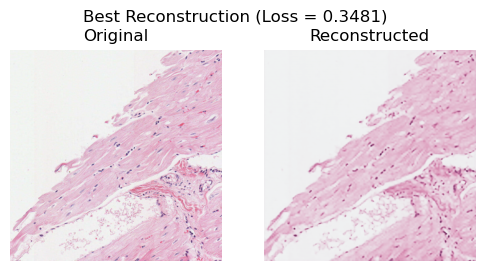

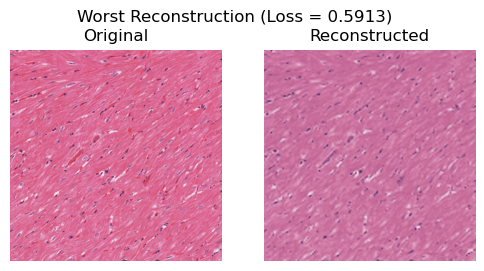

In [ ]:
# Show best and worst ... REALLY INTERESTING! 

# Get indices of best and worst
best_idx = np.argmin(per_image_loss)
worst_idx = np.argmax(per_image_loss)

def show_tile_comparison(index, title):
    plt.figure(figsize=(6, 3))
    plt.suptitle(title)

    # Original
    plt.subplot(1, 2, 1)
    plt.imshow(Y[index])
    plt.title("Original")
    plt.axis("off")

    # Reconstruction
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed[index])
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()

show_tile_comparison(best_idx, f"Best Reconstruction (Loss = {per_image_loss[best_idx]:.4f})")
show_tile_comparison(worst_idx, f"Worst Reconstruction (Loss = {per_image_loss[worst_idx]:.4f})")

In [39]:
original_image = Y[0]
print("ORIGINAL IMAGE - Shape: ", original_image.shape, ", Size: ", original_image.size)

latent_vector = latent_vectors[0]
print("LATENT VECTOR - Shape: ", latent_vector.shape, ", Size: ", latent_vector.size)

# Percentage compression achieved.
compression_percentages = []

for original_image, latent_vector in zip(Y, latent_vectors):
    original_size = original_image.size
    latent_size = latent_vector.size
    # Calc percent for each tile
    percent = (1 - (latent_size / original_size)) * 100
    compression_percentages.append(percent)

average_compression = np.mean(compression_percentages)
print("Average compression across all tiles: {:.2f}%".format(average_compression))

ORIGINAL IMAGE - Shape:  (512, 512, 3) , Size:  786432
LATENT VECTOR - Shape:  (128, 128) , Size:  16384
Average compression across all tiles: 97.92%
